In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import glob

import tensorflow as tf

from sklearn.cluster import KMeans
from numpy import unique
from numpy import where
from matplotlib import pyplot
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering

from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_decision_forests as tfdf

from sklearn.datasets import make_classification

print(tf.__version__)

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2.8.0


### Club all the traces together into a single dataframe

In [41]:
path = './traces_core'# use your path
#all_files = glob.glob(path + "/*.h5")
all_files = glob.glob(path + "/dpotrf_T-200_C-1-*.prof*")

li = []

for filename in all_files:
    trace =  pd.HDFStore(filename)
    data = trace.get('/events')
    trace.close()
    
    li.append(data)
    print(filename)

df = pd.concat(li, axis=0, ignore_index=True)


./traces_core/dpotrf_T-200_C-1-0.prof.h5
./traces_core/dpotrf_T-200_C-1-1.prof.h5


In [42]:
print(len(li))

2


# Clean the data

In [43]:
df = df[['begin', 'end', 'taskpool_id', 'task_class_id','chore_id', 'nb_data_items', 'total_data_size', 'priority']].copy()
df['exec_time'] = (df['end'] - df['begin']) * .001 #0.001 nano seconds to micro seconds
df = df.astype(float)

In [44]:
df_class_name = {0: 'dpotrf', 1: 'dtrsm', 2: 'dsyrk', 3: 'dgemm'}

In [45]:

filter = ( (df['task_class_id'] >= 0 ) & ( df['task_class_id'] <= 3 ) & ( df['priority'] >= 0 ) )
#remove all other classes other than dpotrf, dgemm, trsm and syrk
df = df[filter]
df.head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
29702,540672.0,1274317.0,2.0,1.0,0.0,2.0,320000.0,0.0,733.645
29703,1285991.0,1522460.0,2.0,1.0,0.0,2.0,320000.0,0.0,236.469
29704,1527281.0,2250932.0,2.0,1.0,0.0,2.0,320000.0,0.0,723.651
29705,2255751.0,2491630.0,2.0,1.0,0.0,2.0,320000.0,0.0,235.879
29706,2495887.0,2732279.0,2.0,1.0,0.0,2.0,320000.0,0.0,236.392


## integrate likelihood of the data being in cash.
we assume that all the task whose execution time is in the first quartile could have had all its data in the cache. While, the rest of the tasks would have resulted in a cache flush. While predicting we assume that the that the data of the task is not in the cache 

In [46]:
df[df['task_class_id'] == 3].head()

,begin,end,taskpool_id,task_class_id,chore_id,nb_data_items,total_data_size,priority,exec_time
32268,2.921518e+09,2.922080e+09,4.0,3.0,0.0,3.0,960000.0,913267.0,562.221
32270,2.922809e+09,2.923364e+09,4.0,3.0,0.0,3.0,960000.0,885906.0,555.816
32273,2.924392e+09,2.924945e+09,4.0,3.0,0.0,3.0,960000.0,859115.0,552.877
32276,2.925710e+09,2.926241e+09,4.0,3.0,0.0,3.0,960000.0,913261.0,530.389
32278,2.926833e+09,2.947805e+09,4.0,3.0,0.0,3.0,960000.0,857969.0,20971.755


In [47]:
df.reset_index(inplace=True)

----------------- dpotrf [before] -------------------------- 
Min = 261.047
Max = 26939.452
Avg = 612.4458866666671
Std = 2265.925629650725
----------------- dpotrf [after] -------------------------- 
Min = 261.047
Max = 321.807
Avg = 286.353676056338
Std = 11.810031679135365
datapoints removed 5.333333333333334%
----------------- dtrsm [before] -------------------------- 
Min = 235.87900000000002
Max = 142672.547
Avg = 807.6846237710444
Std = 3034.4530774122472
----------------- dtrsm [after] -------------------------- 
Min = 235.87900000000002
Max = 890.686
Avg = 425.29162815746486
Std = 138.9850015526416
datapoints removed 3.0942760942760943%
----------------- dsyrk [before] -------------------------- 
Min = 161.621
Max = 124978.409
Avg = 793.6433523432329
Std = 2688.3983307837425
----------------- dsyrk [after] -------------------------- 
Min = 346.297
Max = 468.72700000000003
Avg = 402.0309024840288
Std = 24.38212986886409
datapoints removed 6.996699669966996%
----------------- dg

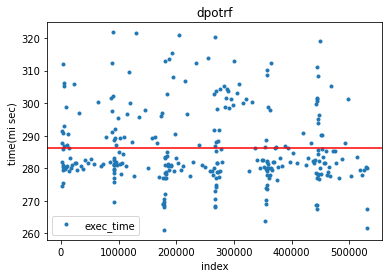

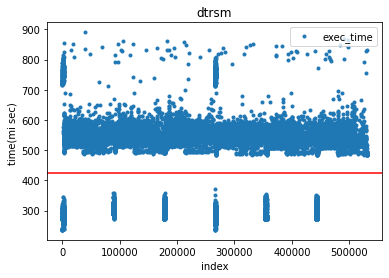

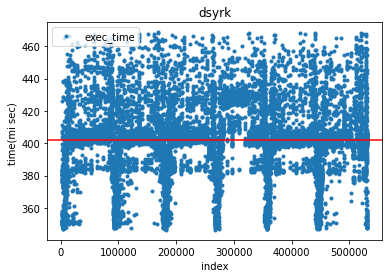

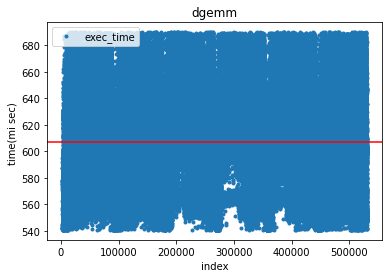

In [48]:
task_class_id = [0,1,2,3]

for i in task_class_id:
    
    df_exaxmple = df
    
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    
    print('----------------- ' + df_class_name[i] + ' [before] -------------------------- ')
    print('Min = ' + str(df_refined['exec_time'].min()))
    print('Max = ' + str(df_refined['exec_time'].max()))
    print('Avg = ' + str(sum(df_refined['exec_time']) / len(df_refined['exec_time'])))
    print('Std = ' + str(df_refined['exec_time'].std()))
    datapoint1 = df_refined.shape[0]
    
    Q1 = df_refined['exec_time'].quantile(0.25)
    Q3 = df_refined['exec_time'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (df_refined['exec_time'] >= Q1 - 1.5 * IQR) & (df_refined['exec_time'] <= Q3 + 1.5 *IQR)
    df_refined = df_refined.loc[filter]
    df_refined = df_refined.astype(float)
    
    print('----------------- ' + df_class_name[i] + ' [after] -------------------------- ')
    print('Min = ' + str(df_refined['exec_time'].min()))
    print('Max = ' + str(df_refined['exec_time'].max()))
    print('Avg = ' + str(sum(df_refined['exec_time']) / len(df_refined['exec_time'])))
    print('Std = ' + str(df_refined['exec_time'].std()))
    datapoint2 = df_refined.shape[0]
    
    perc_of_data = (datapoint1 - datapoint2) / datapoint1 * 100
    print('datapoints removed ' + str(perc_of_data) + '%')
    
    ax = df_refined.plot(y='exec_time',  use_index=True,
                    ylabel='time(mi sec) ', xlabel='index',
                    marker='.', linestyle='none',
                    title=df_class_name[i])
    ax.axhline(sum(df_refined['exec_time']) / len(df_refined['exec_time']), c='r')
    plt.savefig(df_class_name[i]+'_cloud', dpi=300)
    
    

## K-means

ValueError: Single argument to subplot must be a three-digit integer, not <AxesSubplot:>

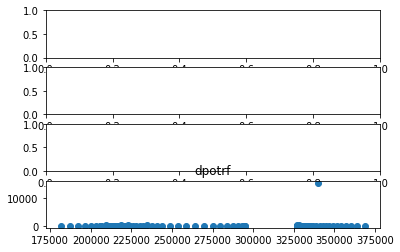

In [64]:
task_class_id = [0,1,2,3]
fig, axs = plt.subplots(4)

for i in task_class_id:
    # define dataset
    df_exaxmple = df
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    x = df_refined[['index', 'exec_time']].copy()
    X = x.to_numpy()
    # define the model
    model = KMeans(n_clusters=3)
    # fit the model
    model.fit(X)
    # assign a cluster to each example
    yhat = model.predict(X)
    # retrieve unique clusters
    clusters = unique(yhat)
    # create scatter plot for samples from each cluster
    for cluster in clusters:
        # get row indexes for samples with this cluster
        row_ix = where(yhat == cluster)
        # create scatter of these samples
        pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
        pyplot.title(df_class_name[i])
        #pyplot.subplot(axs[i])
    # show the plot
    #pyplot.savefig('kmeans_core_1', dpi=300, ax=axs[i], figsize=(8, 20))
    pyplot.show()


## Reorder

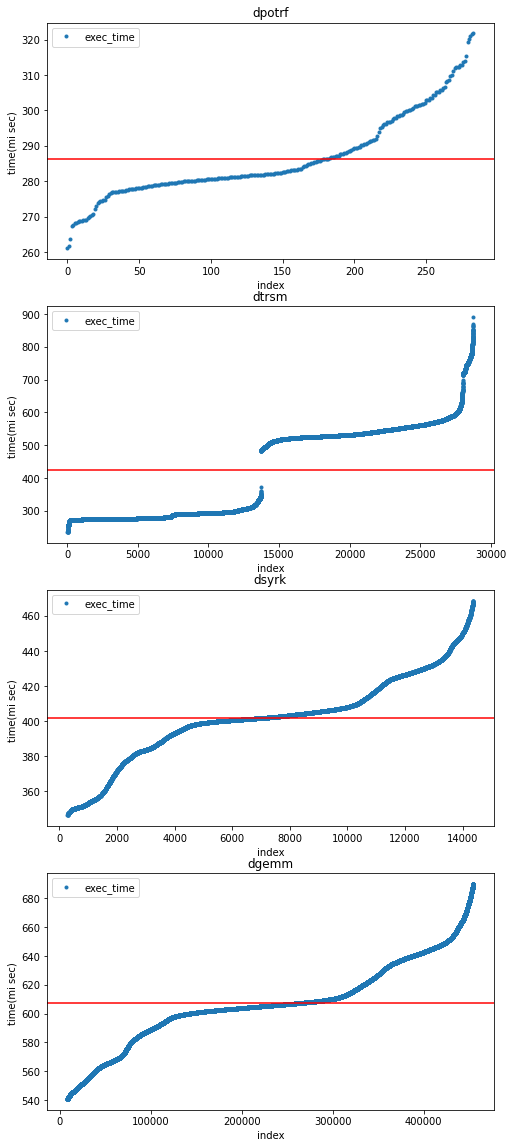

In [57]:
task_class_id = [0,1,2,3]
fig, axs = plt.subplots(4)
for i in task_class_id:
    
    df_exaxmple = df
    
    filter = (df_exaxmple['task_class_id'] == i )
    df_refined = df_exaxmple[filter]
    df_refined = df_refined.sort_values('exec_time', axis=0, ascending=True, 
                                        inplace=False, kind='quicksort', na_position='last')
    df_refined.insert(0, 'new_index', range(0, len(df_refined)))
    
    #print(df_refined.head())
    
    
    Q1 = df_refined['exec_time'].quantile(0.25)
    Q3 = df_refined['exec_time'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range.
    filter = (df_refined['exec_time'] >= Q1 - 1.5 * IQR) & (df_refined['exec_time'] <= Q3 + 1.5 *IQR)
    df_refined = df_refined.loc[filter]
    df_refined = df_refined.astype(float)
    
    
    
    ax = df_refined.plot(y='exec_time',  x='new_index',
                    ylabel='time(mi sec) ', xlabel='index',
                    marker='.', linestyle='none',
                    title=df_class_name[i], ax=axs[i], figsize=(8, 20))
    
    ax.axhline(sum(df_refined['exec_time']) / len(df_refined['exec_time']), c='r')
    #plt.savefig(df_class_name[i]+'_reorder', dpi=300)
plt.savefig('reorder_core 1', dpi=300)    
    
    
